<a href="https://colab.research.google.com/github/Navodit-Sahai/VisionTransformer-from-scratch/blob/main/VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader as dataloader
import torch.nn as nn

In [2]:
#transformation to PIL to tensor format

transformation_operation=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [3]:
train_dataset=torchvision.datasets.MNIST(root="./data",train=True, download=True,transform=transformation_operation)
val_dataset=torchvision.datasets.MNIST(root="./data",train=False, download=False,transform=transformation_operation)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.96MB/s]


In [22]:
#Define datasets batches
train_loader= dataloader(train_dataset,batch_size=64,shuffle=True)
val_loader=dataloader(val_dataset,batch_size=64,shuffle=True)

In [5]:
num_classes=10
batch_size=64 #no. of images in 1 single batch
num_channels=1
img_size=28
patch_size=7
num_patches=(img_size//batch_size)**2
embedding_dim=64
attention_heads=4
transformer_blocks=4
learning_rate=0.001
mlp_hidden_nodes=128
epochs=5

In [6]:
#Part 1: Patch_embeddings
#Part 2: Transformer encoder
#Part 3: MLP_head

VISION TRANSFORMERS DOESN'T HAVE OVERLAPPING PIXELS => NON OVERLAPPING PATCHES ARE REQUIRED

In [7]:
datapoint,label=next(iter(train_loader))
print("shape of datapoint=", datapoint.shape)
patch_embed=nn.Conv2d(num_channels,embedding_dim,kernel_size=patch_size,stride=patch_size)
output_tensor = patch_embed(datapoint)
print("shape after patch_embed=", output_tensor.shape)

shape of datapoint= torch.Size([64, 1, 28, 28])
shape after patch_embed= torch.Size([64, 64, 4, 4])


we need to flatten the patches- 4 along length and 4 along width=> from index 2

Here in patch_embed [64 (batch_size)= num of images in 1 batch,64(size of embeddings),4(no. of patches along length),4(no. of patch along width)]

In [8]:
output_tensor.flatten(2).shape

torch.Size([64, 64, 16])

In [9]:
#to display it in correct form i.e (1.) no. of images in 1 batch (2.) no. of patches in 1 image (3.) dimension of each patch
output_tensor.flatten(2).transpose(1,2).shape

torch.Size([64, 16, 64])

finally we get 16 patches of 1 single image of dim 7*7 arranged in a 1D array

In [10]:
# 1 batch= 64 images------> 1 image= 16 patches-------> 1 patch= 64*64 dimension

In [18]:
class PatchEmbeddings(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed= nn.Conv2d(num_channels,embedding_dim,kernel_size= patch_size,stride=patch_size) #using stride=patch_size we are assuring that we are producing non overlapping patches of the size patch_size.

  def forward(self,x):
    x=self.patch_embed(x)
    x=x.flatten(2)
    x=x.transpose(1,2)
    return x

In [12]:
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1= nn.LayerNorm(embedding_dim)
    self.layer_norm2= nn.LayerNorm(embedding_dim)
    self.multihead_attention= nn.MultiheadAttention(embed_dim=embedding_dim,num_heads=attention_heads,batch_first=True)
    self.mlp= nn.Sequential(
        nn.Linear(embedding_dim,mlp_hidden_nodes), #expanding the dimension
        nn.GELU(),# applying GELU activation to the expanded dimensions
        nn.Linear(mlp_hidden_nodes,embedding_dim)# converting it to its orginal embedding dimension
    )

  def forward(self,x):
    residual1=x
    x= self.layer_norm1(x)
    x=self.multihead_attention(x,x,x)[0] #query,key,value
    x=x+residual1
    residual2=x
    x=self.layer_norm2(x)
    x=self.mlp(x)
    x=x+residual2

    return x

In [13]:
class MLP_head(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1= nn.LayerNorm(embedding_dim)
    self.mlp_head=nn.Linear(embedding_dim,num_classes)

  def forward(self,x):
    x=self.layer_norm1(x)
    x=self.mlp_head(x)

    return x

In [20]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding =PatchEmbeddings()
    #class token need to be passed into MLP_head along with embeddings
    self.cls_token=nn.Parameter(torch.randn(1,1,embedding_dim))
    #positional embedding need to be passed also
    self.positional_embedding=nn.Parameter(torch.randn(1,num_patches+1,embedding_dim)) #patch number should be between (16 patches + 1 because we also passing class token with patches)
    self.transformer_blocks=nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)])
    self.mlp_head=MLP_head()

  def forward(self,x):
    x=self.patch_embedding(x)
    B=x.size(0)
    class_tokens=self.cls_token.expand(B,-1,-1) #we need 1 classification token for each image => 1 cls_token for 1 img/16patches. So for 64 images we require 64 token, 1 cls_token is of dim 64
    x=torch.cat([class_tokens,x],dim=1)
    x=x+self.positional_embedding
    x=self.transformer_blocks(x)
    x=x[:,0]
    x=self.mlp_head(x)
    return x

In [21]:
model=VisionTransformer()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)


In [23]:
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
  model.train() # Set model to training mode
  total_train_loss = 0
  correct_train = 0
  total_train = 0

  for i, (images, labels) in enumerate(train_loader):
    optimizer.zero_grad() # Zero the parameter gradients
    outputs = model(images) # Forward pass
    loss = criterion(outputs, labels) # Calculate loss
    loss.backward() # Backward pass
    optimizer.step() # Optimize

    total_train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total_train += labels.size(0)
    correct_train += (predicted == labels).sum().item()

  print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {total_train_loss/len(train_loader):.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%')

  # Validation phase
  model.eval() # Set model to evaluation mode
  correct_val = 0
  total_val = 0
  with torch.no_grad(): # Disable gradient calculation during validation
    for images, labels in val_loader:
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total_val += labels.size(0)
      correct_val += (predicted == labels).sum().item()

  print(f'Validation Accuracy: {100 * correct_val / total_val:.2f}%')

Epoch [1/5], Train Loss: 0.7677, Train Accuracy: 74.08%
Validation Accuracy: 89.04%
Epoch [2/5], Train Loss: 0.2866, Train Accuracy: 91.02%
Validation Accuracy: 93.02%
Epoch [3/5], Train Loss: 0.2073, Train Accuracy: 93.47%
Validation Accuracy: 93.28%
Epoch [4/5], Train Loss: 0.1659, Train Accuracy: 94.66%
Validation Accuracy: 94.47%
Epoch [5/5], Train Loss: 0.1394, Train Accuracy: 95.47%
Validation Accuracy: 94.88%


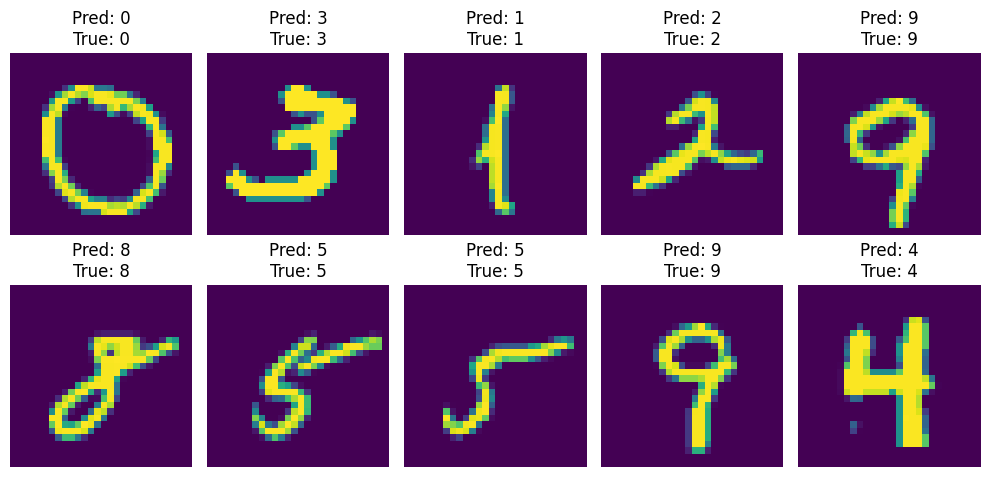

In [24]:
import matplotlib.pyplot as plt
import numpy as np

model.eval() # Set the model to evaluation mode

# Get a batch of validation images and labels
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Function to show an image
def imshow(img, title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Display images and predictions for the first few items in the batch
fig = plt.figure(figsize=(10, 5))
for i in range(min(10, len(images))): # Display up to 10 images
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(f"Pred: {predicted[i].item()}\nTrue: {labels[i].item()}")
plt.tight_layout()
plt.show()